# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

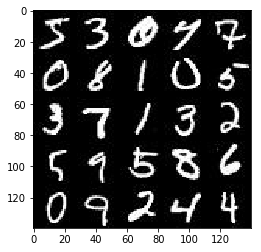

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [ ]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 14x14x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 14x14x256
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # 7x7x512
        flat = tf.reshape(relu4, (-1, 7*7*512)) 
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected
        x1 = tf.layers.dense(z, (7*7*512))
        
        # reshape to start the conv
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1) #leaky relu

        # 7x7x512
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2) #leaky relu
        
        # 14x14x256
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3) #leaky relu
        
        # 14x14x128
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4) #leaky relu
    
        # 14x14x64
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]

    # optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_channels = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[1], img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                # random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 5 == 0:
                    # get train losses and print
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.7568... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 2.6192... Generator Loss: 0.1624
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.4392
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 2.6761
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.6251
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.7568
Epoch 1/2... Discriminator Loss: 1.8348... Generator Loss: 0.4155
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 2.0992
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 0.9677
Epoch 1/2.

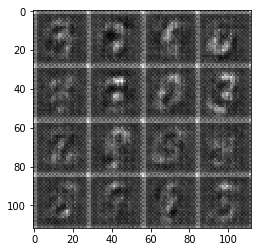

Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.6175
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.4214
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 3.0704
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 1.2056
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 3.0851
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 2.4044
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 0.6408... Generator Loss: 1.6844
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 1.2427
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.8863
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.3048
Epoch 1/2.

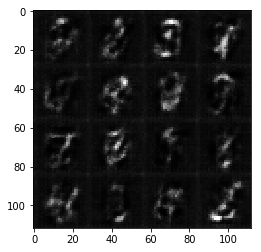

Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.5900
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.6135
Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.8201
Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.9942
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 2.1001
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.3876
Epoch 1/2... Discriminator Loss: 0.5733... Generator Loss: 2.0720
Epoch 1/2... Discriminator Loss: 0.6377... Generator Loss: 2.5000
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 2.1882
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.9493
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 2.8532
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 2.6250
Epoch 1/2.

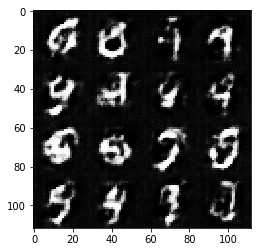

Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 3.0352
Epoch 1/2... Discriminator Loss: 0.5652... Generator Loss: 2.6398
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.5879
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.2578
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 3.5652
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 0.6233... Generator Loss: 1.5916
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 3.4567
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 1.9553
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.9519
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 2.1521
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.0422
Epoch 1/2.

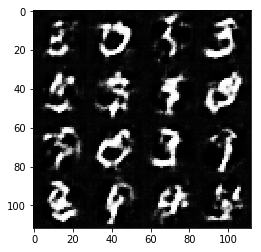

Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 1.8585
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 1.8425
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.3921
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 3.7072
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 2.3276
Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 2.3975
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.8793
Epoch 1/2... Discriminator Loss: 0.6866... Generator Loss: 1.4687
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.6322
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.5183
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 2.7183
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 2.8102
Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 1.5911
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 2.0635
Epoch 2/2.

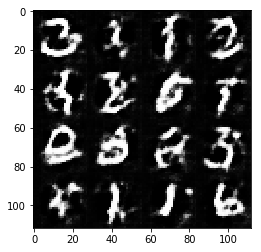

Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 3.0349
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.3739
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.9879
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.0702
Epoch 2/2... Discriminator Loss: 2.0119... Generator Loss: 3.6809
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.4552
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 2.2427
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.8693
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.8070
Epoch 2/2.

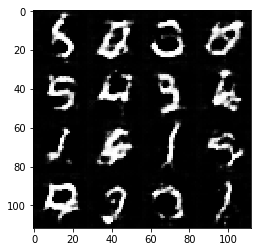

Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.6048
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.4255
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.7317
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.7817
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.8145
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 0.7916... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.4365
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.5323
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.8852... Generator Loss: 3.3148
Epoch 2/2.

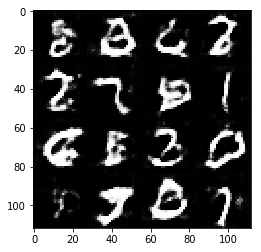

Epoch 2/2... Discriminator Loss: 1.7211... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.8604
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.8536
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 2.4184... Generator Loss: 4.1524
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.5769
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 2.0915
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.8967
Epoch 2/2.

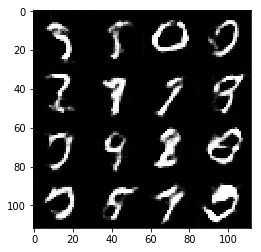

Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.5351
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.4559
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 5.0555... Generator Loss: 7.0630
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.4605
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 2.2010
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 1.5318
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.4217
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.6439
Epoch 2/2... Discriminator Loss: 0.6999... Generator Loss: 1.3822
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 4.7305... Generator Loss: 0.0292
Epoch 2/2.

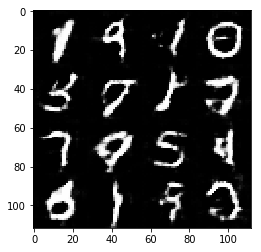

Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.5014
Epoch 2/2... Discriminator Loss: 1.6646... Generator Loss: 0.3674
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 2.0072
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.3917
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.3080


In [55]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 2.1109
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.6676
Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.6901
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.8171
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.5106
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 3.8638... Generator Loss: 13.1752
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 2.1236
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 2.7445
Epoch 1/1

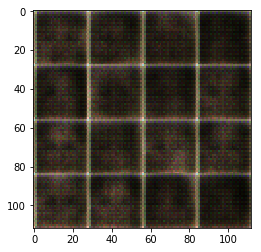

Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.3193
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.6742
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.5069
Epoch 1/1.

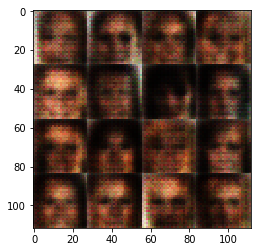

Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.8995
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.9065
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 3.1989
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 2.8381
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8981
Epoch 1/1.

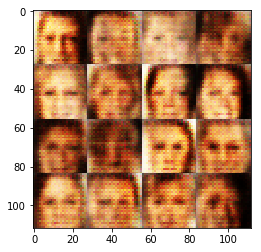

Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 2.6542
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 2.7967
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.5207
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 2.5267
Epoch 1/1.

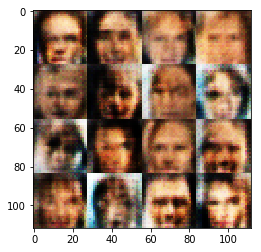

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.6463
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 3.5522
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 3.2638
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 2.0010
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9831
Epoch 1/1.

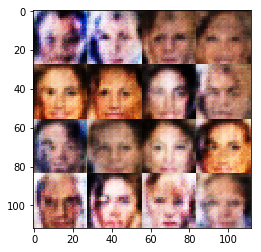

Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 3.6497
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 3.4174
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.8417
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 2.1551
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 4.3638
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 5.0567
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 2.1760
Epoch 1/1.

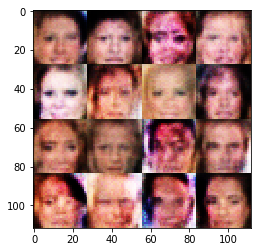

Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 3.3254
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 3.4849
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 2.4414
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 2.1258
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 3.5904
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.4478
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 3.3284
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.1228
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.1409
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 3.3071
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.9303
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.4492
Epoch 1/1.

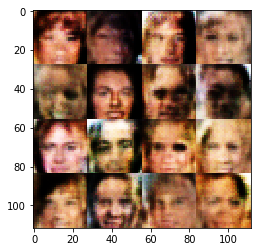

Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 3.0003
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.7514
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 2.2304
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.0011
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.5967
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 5.1343
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9750
Epoch 1/1.

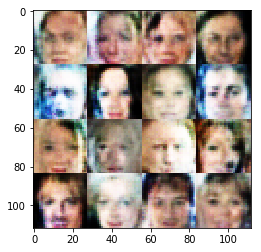

Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.5029
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 4.5842
Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 3.9060
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 3.7314
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 2.5970
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.7777
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 4.1775
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 2.1389
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 2.6372
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.9614
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4639
Epoch 1/1.

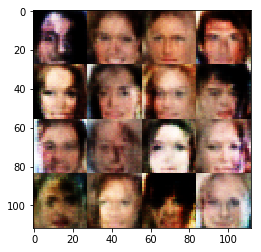

Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 3.3999
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 3.7984
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.8086
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 5.7713
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.2197
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.3001
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 4.7565
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 3.0010
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 2.9247
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 3.0802
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6490
Epoch 1/1.

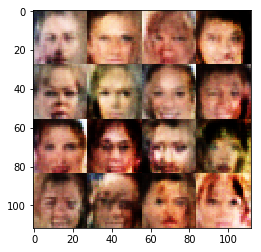

Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.2779
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 4.0106
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 5.4982
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.3234
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.3771
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 3.0443
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.9874
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 4.0422
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 7.5739
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.9721
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 3.4937
Epoch 1/1.

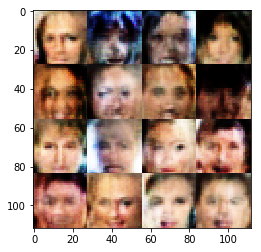

Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.5573
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.6877
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 5.1415
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.8860
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.4364
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 4.0324
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.1098
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 4.3053
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 3.0306
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 7.0555
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.3713
Epoch 1/1.

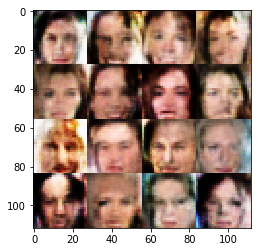

Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 2.0552
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 2.2033
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 3.5849
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.7568
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.0980
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.6896
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.7304
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 2.3374
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 5.2716
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 6.0426
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.3460
Epoch 1/1.

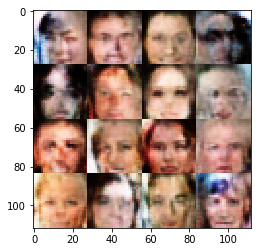

Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 3.2465... Generator Loss: 0.1242
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.3836
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 3.0978
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 5.0315
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.3996
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.9790
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 3.1566
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 2.5742
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 2.4428
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 4.0450
Epoch 1/1.

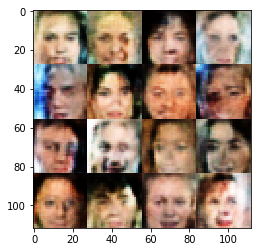

Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.8612
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.6328
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.2749
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 3.1802
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 2.9682
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 5.0216
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.5619
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 2.5529
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.6479
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 4.7217
Epoch 1/1... Discriminator Loss: 2.5802... Generator Loss: 0.1919
Epoch 1/1... Discriminator Loss: 4.5502... Generator Loss: 0.0350
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 2.4983
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.3194
Epoch 1/1.

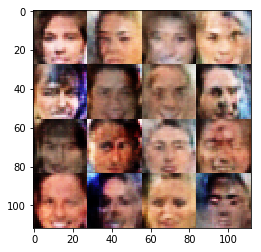

Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.0174
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 2.0012
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.8462
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 3.1039
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 4.0216
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 3.3560
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 2.2603
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 2.8475
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 3.7595
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.2543
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.4687
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 3.3187
Epoch 1/1.

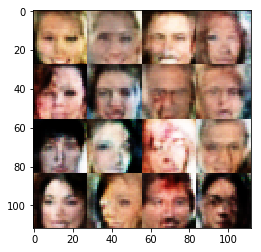

Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 5.0527
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 4.1225
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 4.1444
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 3.6082
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 3.1611
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.2875
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 4.2584
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.2973
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.8508
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.8101
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 5.2875
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.1963
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 4.6522
Epoch 1/1... Discriminator Loss: 2.9992... Generator Loss: 0.1150
Epoch 1/1.

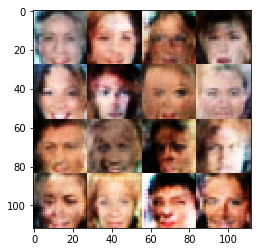

Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.5660
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 1.9923
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.1078
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 4.9190
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 4.5977
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.6221
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 1.8907
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 4.4373
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 2.5163
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 3.8429
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.1987
Epoch 1/1.

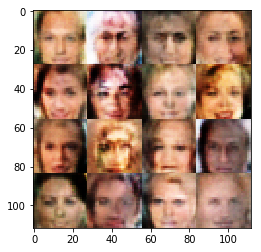

Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 4.1485
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.0374
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.1305
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 1.9033
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.9048
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 4.7135
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 5.3752
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.3969
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 3.0403
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 2.8188
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 3.9096
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.2179
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 2.0411
Epoch 1/1.

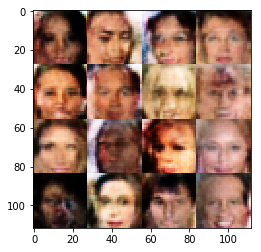

Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 2.1407
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 2.9023
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 1.7019
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.9910
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 6.3973
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 4.0892
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 2.4660
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.2856
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.9218
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.4063
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.6183
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.1406
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 4.6100
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 2.6059
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.0002
Epoch 1/1.

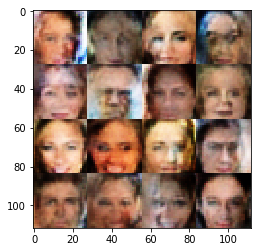

Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 3.2178
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 4.3116
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.1838
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 4.0506
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 3.3170
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 3.2771
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 1.9247
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 2.3413
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 2.5224
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 3.4982
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.6222
Epoch 1/1.

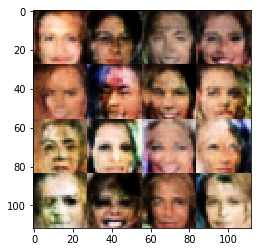

Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.6490
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.3195
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.8090
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 2.6132
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.4081
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 2.0714
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 4.7512
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.2888
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.7813
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.2250
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 3.5287
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 3.7690
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 3.9336
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 4.1618
Epoch 1/1.

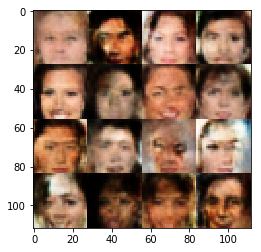

Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 4.2036
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.9133
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.2719
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 3.3756
Epoch 1/1... Discriminator Loss: 3.5200... Generator Loss: 5.0075
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.8677
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 2.8410
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.7905
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 3.2944
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 3.2025
Epoch 1/1.

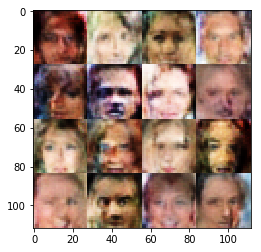

Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 2.2631
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.9018
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.7840
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.1910
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.6917
Epoch 1/1... Discriminator Loss: 2.0855... Generator Loss: 4.7219
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 2.9206
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.7857
Epoch 1/1.

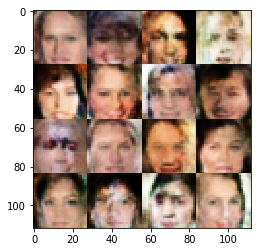

Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 2.0977
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.7508
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 2.3128
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.0784
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.1371
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 4.1962
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 2.9947
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.6545
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 3.2017
Epoch 1/1.

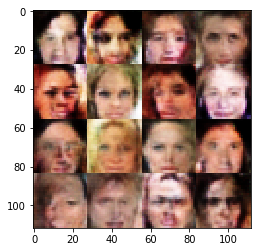

Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.9170
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 3.3315
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.6448
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 4.5341
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 2.1161
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 3.2574
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.7991
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 2.8511
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 2.0557
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.8027
Epoch 1/1.

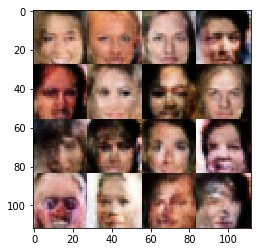

Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.8412
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.1242
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.1724
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 5.7171
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 3.0842
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.9750
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.0323
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 3.8234
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.7668
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 5.2022
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.4334
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.8664
Epoch 1/1.

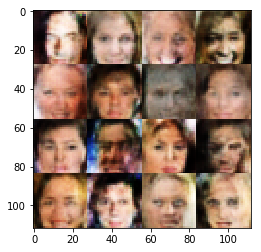

Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 3.5219
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.8874
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.9479
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 2.2670
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 2.9523
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.8020... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 2.8851
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.2679
Epoch 1/1.

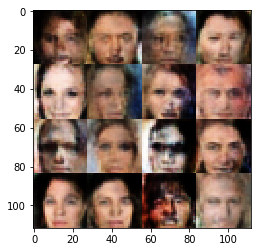

Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 2.3780
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 3.0231
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.2274
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 3.8153
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 4.0447
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 4.0906
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 3.9379
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.2089
Epoch 1/1.

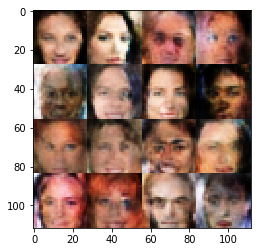

Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.3923
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.6449
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 5.6022
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.2911
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 3.0839
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 2.9280
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.4692
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.9395
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.4014
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.7810
Epoch 1/1.

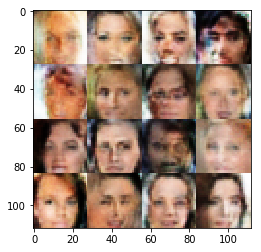

Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.1875
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.0597
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.8765
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 2.9927
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 4.0975
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.3760
Epoch 1/1.

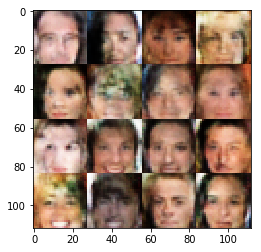

Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 5.4876
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 3.0034
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.1833
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 3.1805
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 3.5780
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.6735
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 2.6571
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.7625
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 2.2175
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 5.3381
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.8132
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 2.6484


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.